# **(Predict House Price Nootebook)**

## Objectives

* Develop and assess a predictive model for estimating the sale values of inherited properties.

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csvk

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* Feature Importance Plot
* Model performance plot

## Additional Comments

* In the begining of the project we made an hypothesis, after the taken steps we can make an conclusion that the hypothesis was true, we see that size, quality and the year the house was built matters on the price. I will also credit coce institute and https://github.com/Amareteklay/ who i followed. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housepricepred2/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/housepricepred2'

## Load Data

Start by loading data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv") 

print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

## MP Pipeline: Regressor

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
# Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer


def PipelineDataCleaningAndFeatureEngineering():
    pipeline = Pipeline([
        ('impute_mean', MeanMedianImputer(imputation_method='mean', variables=['LotFrontage', 'BedroomAbvGr'])),
        ('impute_median', MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea'])),
        ('impute_categorical', CategoricalImputer(imputation_method='frequent', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),
        ('drop_features', DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF'])), 
        ('encoder', OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        ('log_transformer', vt.LogTransformer(variables=['GrLivArea', 'LotArea', 'LotFrontage'])),
        ('power_transformer', vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])),
        ('outlier_handler', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])),  
        ('smart_corr_sel', SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
    ])

    return pipeline
    


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('impute_mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('impute_median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('impute_categorical',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure'])),
                ('drop_features',
                 DropFeatures(f...
                 PowerTransformer(variables=['GarageArea', 'MasVnrArea',
                                             'OpenPorchSF', 'TotalBsmtSF',
                                             '1stFlrSF', '2ndFlrSF'])),
                ('outlier_handler',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GarageArea', 'LotArea', 'LotFr

In [12]:
from sklearn.pipeline import Pipeline

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Models
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def OptimizeModelPipeline(model):
    pipeline = Pipeline([
        ('feat_scaling', StandardScaler()),
        ('feat_selection', SelectFromModel(model)),
        ('model', model)
    ])

    return pipeline

* taken from code institute

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.models.keys():
            try:
                print(f"\nRunning GridSearchCV for {key}\n")
                
                model = OptimizeModelPipeline(self.models[key])
                
                params = self.params[key]
                gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, error_score='raise')
                gs.fit(X, y)
                self.grid_searches[key] = gs
            except Exception as e:
                print(f"Error encountered for model {key}: {e}")

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))
        
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train and Test Set

In [21]:


from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [22]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 17) (1168,) (292, 17) (292,)


/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


## Grid Search CV - Sklearn

In [23]:
# Set up a dictionary of various regression models with default settings
initial_models = {
    "Linear_Reg": LinearRegression(),
    "Decision_Tree": DecisionTreeRegressor(random_state=0),
    "Random_Forest": RandomForestRegressor(random_state=0),
    "Extra_Trees": ExtraTreesRegressor(random_state=0),
    "AdaBoost": AdaBoostRegressor(random_state=0),
    "Gradient_Boosting": GradientBoostingRegressor(random_state=0),
    "XGBoost": XGBRegressor(random_state=0),
}

# Define hyperparameters for a quick comparison of models
model_hyperparams = {
    "Linear_Reg": {},

    "Decision_Tree": {
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "Random_Forest": {
        'model__n_estimators': [100, 50, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "Extra_Trees": {
        'model__n_estimators': [100, 50, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
    },

    "AdaBoost": {
        'model__n_estimators': [50, 25, 80, 150],
        'model__learning_rate': [1, 0.1, 2],
        'model__loss': ['linear', 'square', 'exponential'],
    },

    "Gradient_Boosting": {
        'model__n_estimators': [100, 50, 140],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 15, None],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "XGBoost": {
        'model__n_estimators': [30, 80, 200],
        'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
        },
}

In [24]:
search = HyperparameterOptimizationSearch(models=initial_models, params=model_hyperparams)
search.fit(X_train, y_train, cv=5, n_jobs=-1, verbose=1, scoring='r2')



Running GridSearchCV for Linear_Reg

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Decision_Tree

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for Random_Forest

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for Extra_Trees

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoost

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for Gradient_Boosting

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBoost

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will b

We run a summary and check results

In [25]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
97,Extra_Trees,0.672572,0.771646,0.822827,0.056547,None,NaN,1,2,100,NaN,NaN,NaN
121,Extra_Trees,0.668049,0.769966,0.817808,0.056815,15,NaN,1,2,100,NaN,NaN,NaN
99,Extra_Trees,0.667966,0.769001,0.819728,0.057499,None,NaN,1,2,150,NaN,NaN,NaN
98,Extra_Trees,0.676231,0.768802,0.819056,0.05484,None,NaN,1,2,50,NaN,NaN,NaN
123,Extra_Trees,0.662066,0.768464,0.818357,0.05974,15,NaN,1,2,150,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,XGBoost,-6.296405,-5.096129,-4.398517,0.639904,3,NaN,NaN,NaN,30,0.001,NaN,0.1
409,XGBoost,-6.295992,-5.096449,-4.397217,0.639734,15,NaN,NaN,NaN,30,0.001,NaN,0
436,XGBoost,-6.295992,-5.096449,-4.397217,0.639734,15,NaN,NaN,NaN,30,0.001,NaN,0.1
430,XGBoost,-6.296193,-5.096513,-4.397193,0.639804,None,NaN,NaN,NaN,30,0.001,NaN,0.1


## Do an extensive search on the most suitable model to find the best hyperparameter configuration.


* The first step we take is to create a model with parameters

In [26]:
initial_models = {
    "Extra_Trees": ExtraTreesRegressor(random_state=0),
}
model_hyperparams = {
    "Extra_Trees":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

* Then we do as before and running an extensive GridSearch CV

In [27]:
search = HyperparameterOptimizationSearch(models=initial_models, params= model_hyperparams)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for Extra_Trees

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [28]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,Extra_Trees,0.672572,0.771646,0.822827,0.056547,None,1,2,100
25,Extra_Trees,0.668049,0.769966,0.817808,0.056815,15,1,2,100
2,Extra_Trees,0.667966,0.769001,0.819728,0.057499,None,1,2,150
0,Extra_Trees,0.676231,0.768802,0.819056,0.05484,None,1,2,50
26,Extra_Trees,0.662066,0.768464,0.818357,0.05974,15,1,2,150
28,Extra_Trees,0.704919,0.767047,0.809652,0.044642,15,1,50,100
4,Extra_Trees,0.704919,0.766726,0.810396,0.045004,None,1,50,100
29,Extra_Trees,0.700898,0.765366,0.809338,0.045508,15,1,50,150
5,Extra_Trees,0.700898,0.765161,0.809159,0.045726,None,1,50,150
27,Extra_Trees,0.690429,0.76444,0.810835,0.047909,15,1,50,50


* We looking for the optimize model

In [29]:
optimal_model = grid_search_summary.iloc[0]['estimator']
optimal_model

'Extra_Trees'

* Extract the best parameters for the top-performing model

In [30]:
optimal_parameters = grid_search_pipelines[optimal_model].best_params_
optimal_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

* Assign the most effective regression model from the grid search results

In [31]:
optimal_regression_pipeline = grid_search_pipelines[optimal_model].best_estimator_
optimal_regression_pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model', ExtraTreesRegressor(random_state=0))])

### Assess feature importance

In [32]:
X_train.head(3)

,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,TotalBsmtSF,YearBuilt,YearRemodAdd
618,0.0,2.883272,0,48,0,1774,27.820855,0,0,9.366831,4.499810,21.260292,10.392305,5,42.684892,2007,2007
870,0.0,2.000000,1,0,0,894,17.549929,0,1,8.794825,4.094345,0.000000,0.000000,5,29.899833,1962,1962
92,0.0,2.000000,1,713,1,163,20.784610,0,1,9.500020,4.382027,0.000000,0.000000,7,29.597297,1921,2006


* These are the 6 most important features in descending order. The model was trained on them: 
['TotalBsmtSF', 'GarageArea', 'YearBuilt', '2ndFlrSF', 'KitchenQual', 'YearRemodAdd']


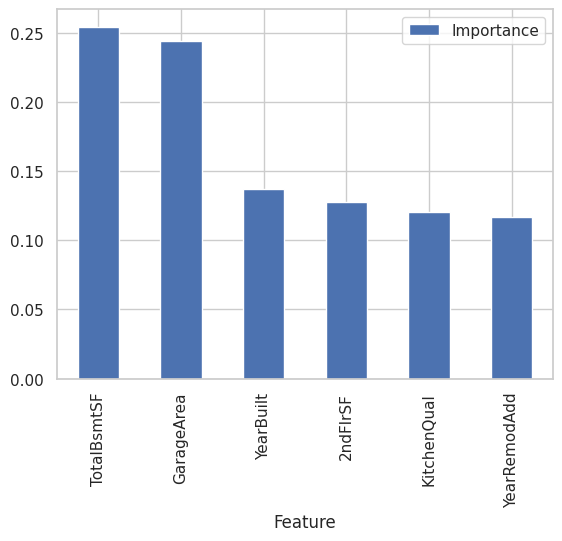

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[optimal_regression_pipeline['feat_selection'].get_support()],
    'Importance': optimal_regression_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

* We put as BR2 to have a score on both train and test set on 0.75 so we need to check the performance

In [35]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    r2_train = regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    r2_test = regression_evaluation(X_test, y_test, pipeline)

    # Performance Check
    check_performance_goal(r2_train, r2_test)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    r2 = r2_score(y, prediction)
    print('R2 Score:', r2.round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")
    return r2

def check_performance_goal(r2_train, r2_test):
    if r2_train < 0.75:
        print("Warning: R2 score on the train set is below the goal of 0.75.")
    if r2_test < 0.75:
        print("Warning: R2 score on the test set is below the goal of 0.75.")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_title(f"Train Set - R2: {r2_train:.3f}")
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_title(f"Test Set - R2: {r2_test:.3f}")
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")

    directory = 'docs/plots'
    if not os.path.exists(directory):
        os.makedirs(directory)


    plt.savefig('docs/plots/regression_performance.png', bbox_inches='tight')  
    plt.show()

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 130.159
Mean Squared Error: 855919.443
Root Mean Squared Error: 925.159


* Test Set
R2 Score: 0.813
Mean Absolute Error: 22383.126
Mean Squared Error: 1294112311.366
Root Mean Squared Error: 35973.773




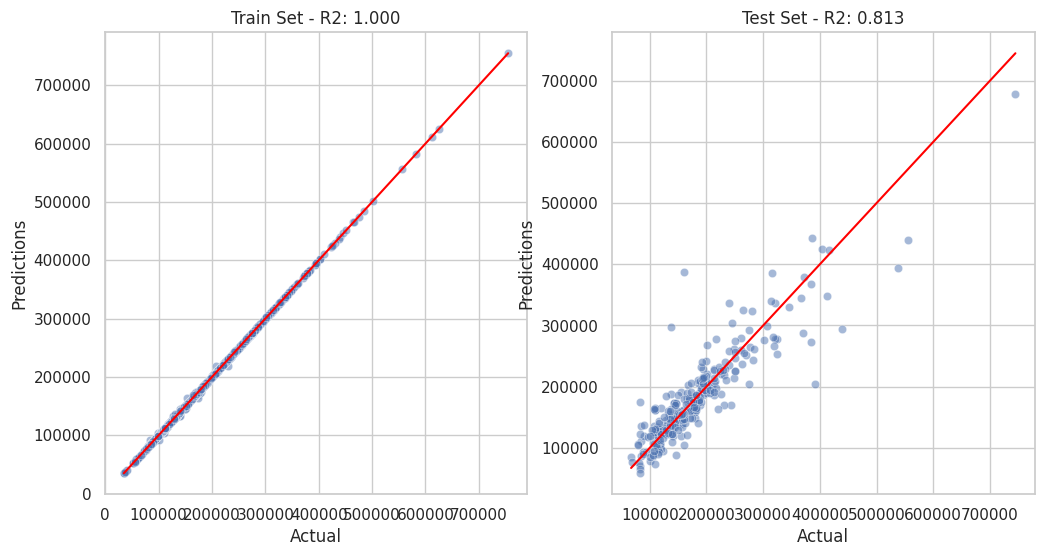

In [36]:
regression_performance(X_train, y_train, X_test, y_test, optimal_regression_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, optimal_regression_pipeline)

---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
